In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import sklearn as sk
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn import impute
from sklearn import preprocessing
from sklearn.impute import KNNImputer
import itertools
import time

# Work from Rakin's Week 4 code
data = pd.read_csv("owid-covid-data-1.csv")
data.shape

# missingness
missing = pd.DataFrame(data.isnull().sum())
missing['% missing'] = data.isnull().sum()/data.shape[0]
missing.columns = ["Missing Count", "Proportion Missing"]
missing = missing.sort_values(by="Proportion Missing", ascending=True)

# Finding number of missing values for each column
data.apply(lambda x: x.isnull().sum())

missing = missing[missing["Proportion Missing"] < .20]
missing

# Work from Sid's Week 5 work (updated on 'Missingness EDA' Jupyter nootbook Python file)
acceptable_columns = list(missing.index.values)
acceptable_columns

continent_data = data.groupby("location").count()
continent_data = continent_data.drop(columns=[col for col in continent_data if col not in acceptable_columns])
continent_data

missing2 = pd.DataFrame(continent_data.sum(axis=1))
missing2['% missing'] = 1 - (missing2/19350)
missing2 = missing2[missing2["% missing"] < .20]
missing2

acceptable_locations = list(missing2.index.values)
acceptable_locations

new_data = data[data['location'].isin(acceptable_locations)]
new_data = new_data.drop(columns=[col for col in new_data if col not in acceptable_columns])
new_data

list(new_data.dtypes)

list(new_data.columns)

# Dropping the columns with non-numeric values from new_data
new_data_numeric = new_data.drop(columns=['iso_code', 'location', 'date', 'continent'])

# Techniques for imputing on missing data
#Website source: https://www.datacamp.com/tutorial/techniques-to-handle-missing-data-values

## Missing At Random: (1) Multiple imputation - MICE (2) Regression imputation
#For MAR, the probability of the value being missing is related to the value of the variable or other variables in the dataset. This means that not all the observations and variables have the same chance of being missing. In the context of our dataset and problem, a lot of our missing data comes from low-income or low GDP countries and most notably from the time period of February/March 2020 until April/May 2020.

## Missing Not At Random: (1) Pattern Substitution (2) Maximum Likelihood estimation
#MNAR is considered to be the most difficult scenario among the three types of missing data. It is applied when neither MAR nor MCAR apply. In this situation, the probability of being missing is completely different for different values of the same variable, and these reasons can be unknown to us. Here in our case, the most likely reason for our countries having missing data is because testing for COVID had not started yet so the values were truly unknown. Some countries implemented testing sooner than others, and some of them may have withheld their data for a long time before sharing it.

# Filling missing values: Method 1 - Naive way
#new_data_naive = new_data_numeric.fillna(method = 'ffill')

# Filling missing values: Method 2 - mputing missing values as the mean of non-missing values
# new_data_mean = new_data_numeric.fillna(new_data_numeric.mean())

### KNN
# Imputing based on similar values next to or nearby the missing values

# Filling missing values: Method 3 - KNN Imputation

# creating a data frame from the list
Before_imputation = pd.DataFrame(new_data_numeric)

# printing dataset before imputation
print("Data Before performing imputation\n", Before_imputation)

Data Before performing imputation
         total_cases  new_cases  new_cases_smoothed  total_deaths  new_deaths  \
0               5.0        5.0                 NaN           NaN         NaN   
1               5.0        0.0                 NaN           NaN         NaN   
2               5.0        0.0                 NaN           NaN         NaN   
3               5.0        0.0                 NaN           NaN         NaN   
4               5.0        0.0                 NaN           NaN         NaN   
...             ...        ...                 ...           ...         ...   
166321     236871.0      491.0             413.000        5395.0         0.0   
166322     237503.0      632.0             416.286        5396.0         1.0   
166323     237503.0        0.0             362.286        5396.0         0.0   
166324     238739.0     1236.0             467.429        5397.0         1.0   
166325     239019.0      280.0             459.429        5397.0         0.0   

    

In [2]:
# Rakin's Week 5 Work
# scaling the data
scaler = sk.preprocessing.StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(Before_imputation))

# creating an object for KNNImputer
# n neighbors chosen: k=sqrt(n)
imputer = KNNImputer(n_neighbors=408, weights = "uniform")
After_imputation = imputer.fit_transform(scaled_data)

# reverse scaling
unscaled_data = scaler.inverse_transform(After_imputation)

# printing dataset after performing the operation
print("\n\nAfter performing imputation\n",unscaled_data)

data_imputed = pd.DataFrame(unscaled_data)

data_imputed.columns = Before_imputation.columns
data_imputed



After performing imputation
 [[5.00000000e+00 5.00000000e+00 1.22342069e+02 ... 9.59000000e+00
  6.48300000e+01 5.11000000e-01]
 [5.00000000e+00 0.00000000e+00 1.22342069e+02 ... 9.59000000e+00
  6.48300000e+01 5.11000000e-01]
 [5.00000000e+00 0.00000000e+00 1.22342069e+02 ... 9.59000000e+00
  6.48300000e+01 5.11000000e-01]
 ...
 [2.37503000e+05 0.00000000e+00 3.62286000e+02 ... 1.82000000e+00
  6.14900000e+01 5.71000000e-01]
 [2.38739000e+05 1.23600000e+03 4.67429000e+02 ... 1.82000000e+00
  6.14900000e+01 5.71000000e-01]
 [2.39019000e+05 2.80000000e+02 4.59429000e+02 ... 1.82000000e+00
  6.14900000e+01 5.71000000e-01]]


,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index
0,5.0,5.0,122.342069,1545.786765,6.245098,6.449223,0.126,0.126,3.071208,38.804277,...,39835428.0,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,64.83,0.511
1,5.0,0.0,122.342069,1545.786765,6.245098,6.449223,0.126,0.000,3.071208,38.804277,...,39835428.0,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,64.83,0.511
2,5.0,0.0,122.342069,1545.786765,6.245098,6.449223,0.126,0.000,3.071208,38.804277,...,39835428.0,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,64.83,0.511
3,5.0,0.0,122.342069,1545.786765,6.245098,6.449223,0.126,0.000,3.071208,38.804277,...,39835428.0,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,64.83,0.511
4,5.0,0.0,122.342069,1545.786765,6.245098,6.449223,0.126,0.000,3.071208,38.804277,...,39835428.0,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,64.83,0.511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130738,236871.0,491.0,413.000000,5395.000000,0.000000,1.000000,15694.959,32.533,27.365000,357.470000,...,15092171.0,42.729,19.6,2.822,1.882,1899.775,307.846,1.82,61.49,0.571
130739,237503.0,632.0,416.286000,5396.000000,1.000000,1.143000,15736.835,41.876,27.583000,357.536000,...,15092171.0,42.729,19.6,2.822,1.882,1899.775,307.846,1.82,61.49,0.571
130740,237503.0,0.0,362.286000,5396.000000,0.000000,0.857000,15736.835,0.000,24.005000,357.536000,...,15092171.0,42.729,19.6,2.822,1.882,1899.775,307.846,1.82,61.49,0.571
130741,238739.0,1236.0,467.429000,5397.000000,1.000000,0.714000,15818.731,81.897,30.972000,357.603000,...,15092171.0,42.729,19.6,2.822,1.882,1899.775,307.846,1.82,61.49,0.571


In [3]:
# Week 6 Work begins now:
# Adding non-numeric columns back to data
new_data_beginning = new_data[['iso_code', 'location', 'date', 'continent']]
new_data_beginning.reset_index(drop=True, inplace=True)
data_imputed.reset_index(drop=True, inplace=True)
data_imputed_all_columns = pd.concat([new_data_beginning, data_imputed], axis=1)
data_imputed_all_columns

,iso_code,location,date,continent,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index
0,AFG,Afghanistan,2020-02-24,Asia,5.0,5.0,122.342069,1545.786765,6.245098,6.449223,...,39835428.0,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,64.83,0.511
1,AFG,Afghanistan,2020-02-25,Asia,5.0,0.0,122.342069,1545.786765,6.245098,6.449223,...,39835428.0,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,64.83,0.511
2,AFG,Afghanistan,2020-02-26,Asia,5.0,0.0,122.342069,1545.786765,6.245098,6.449223,...,39835428.0,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,64.83,0.511
3,AFG,Afghanistan,2020-02-27,Asia,5.0,0.0,122.342069,1545.786765,6.245098,6.449223,...,39835428.0,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,64.83,0.511
4,AFG,Afghanistan,2020-02-28,Asia,5.0,0.0,122.342069,1545.786765,6.245098,6.449223,...,39835428.0,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,64.83,0.511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130738,ZWE,Zimbabwe,2022-03-01,Africa,236871.0,491.0,413.000000,5395.000000,0.000000,1.000000,...,15092171.0,42.729,19.6,2.822,1.882,1899.775,307.846,1.82,61.49,0.571
130739,ZWE,Zimbabwe,2022-03-02,Africa,237503.0,632.0,416.286000,5396.000000,1.000000,1.143000,...,15092171.0,42.729,19.6,2.822,1.882,1899.775,307.846,1.82,61.49,0.571
130740,ZWE,Zimbabwe,2022-03-03,Africa,237503.0,0.0,362.286000,5396.000000,0.000000,0.857000,...,15092171.0,42.729,19.6,2.822,1.882,1899.775,307.846,1.82,61.49,0.571
130741,ZWE,Zimbabwe,2022-03-04,Africa,238739.0,1236.0,467.429000,5397.000000,1.000000,0.714000,...,15092171.0,42.729,19.6,2.822,1.882,1899.775,307.846,1.82,61.49,0.571


In [4]:
list_of_unique_countries = acceptable_locations

In [5]:
# Removing Outliers Function for New Cases
from scipy import stats
def remove_outliers_zscore(df, threshold=3):
    z_scores_new_cases = np.abs(stats.zscore(df['new_cases']))
    z_scores_new_deaths = np.abs(stats.zscore(df['new_deaths']))
    df_no_outliers = df[(z_scores_new_cases < threshold) & (z_scores_new_deaths < threshold)]
    return df_no_outliers

In [6]:
running_df = data_imputed_all_columns[0:0]
for country in list_of_unique_countries:
    filtered_df = data_imputed_all_columns[data_imputed_all_columns['location'] == country]
    country_data_no_outliers = remove_outliers_zscore(filtered_df, threshold=3)
    running_df = pd.concat([running_df, country_data_no_outliers], axis=0)
    
running_df.reset_index(drop=True, inplace=True)
running_df

,iso_code,location,date,continent,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index
0,AFG,Afghanistan,2020-02-24,Asia,5.0,5.0,122.342069,1545.786765,6.245098,6.449223,...,39835428.0,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,64.83,0.511
1,AFG,Afghanistan,2020-02-25,Asia,5.0,0.0,122.342069,1545.786765,6.245098,6.449223,...,39835428.0,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,64.83,0.511
2,AFG,Afghanistan,2020-02-26,Asia,5.0,0.0,122.342069,1545.786765,6.245098,6.449223,...,39835428.0,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,64.83,0.511
3,AFG,Afghanistan,2020-02-27,Asia,5.0,0.0,122.342069,1545.786765,6.245098,6.449223,...,39835428.0,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,64.83,0.511
4,AFG,Afghanistan,2020-02-28,Asia,5.0,0.0,122.342069,1545.786765,6.245098,6.449223,...,39835428.0,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,64.83,0.511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125823,ZWE,Zimbabwe,2022-03-01,Africa,236871.0,491.0,413.000000,5395.000000,0.000000,1.000000,...,15092171.0,42.729,19.6,2.822,1.882,1899.775,307.846,1.82,61.49,0.571
125824,ZWE,Zimbabwe,2022-03-02,Africa,237503.0,632.0,416.286000,5396.000000,1.000000,1.143000,...,15092171.0,42.729,19.6,2.822,1.882,1899.775,307.846,1.82,61.49,0.571
125825,ZWE,Zimbabwe,2022-03-03,Africa,237503.0,0.0,362.286000,5396.000000,0.000000,0.857000,...,15092171.0,42.729,19.6,2.822,1.882,1899.775,307.846,1.82,61.49,0.571
125826,ZWE,Zimbabwe,2022-03-04,Africa,238739.0,1236.0,467.429000,5397.000000,1.000000,0.714000,...,15092171.0,42.729,19.6,2.822,1.882,1899.775,307.846,1.82,61.49,0.571


# Multivariate Analysis

<AxesSubplot:>

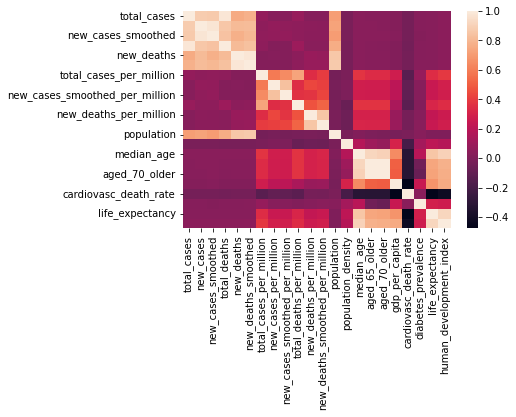

In [7]:
sns.heatmap(running_df.corr())

In [15]:
running_df.corr()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index
total_cases,1.000000,0.878115,0.872507,0.981077,0.753952,0.779950,0.068607,0.027501,0.028806,0.078703,...,0.707745,-0.018778,0.031285,0.028323,0.025134,0.016284,-0.035012,0.022974,0.026664,0.037858
new_cases,0.878115,1.000000,0.975200,0.857201,0.811649,0.816664,0.048275,0.065856,0.056157,0.049911,...,0.725932,-0.018774,0.034644,0.033038,0.030331,0.018601,-0.036022,0.019220,0.029178,0.040764
new_cases_smoothed,0.872507,0.975200,1.000000,0.842272,0.769466,0.799843,0.055507,0.060568,0.070623,0.053617,...,0.703996,-0.018534,0.035027,0.033827,0.031289,0.019559,-0.036372,0.018625,0.029726,0.041127
total_deaths,0.981077,0.857201,0.842272,1.000000,0.812708,0.836935,0.053216,0.015025,0.014293,0.098379,...,0.761699,-0.022995,0.031783,0.027302,0.024182,0.010367,-0.040627,0.022469,0.028301,0.039275
new_deaths,0.753952,0.811649,0.769466,0.812708,1.000000,0.978887,0.014851,0.021006,0.014536,0.047415,...,0.856157,-0.025551,0.034073,0.028800,0.025188,0.009564,-0.036463,0.024300,0.027595,0.041224
new_deaths_smoothed,0.779950,0.816664,0.799843,0.836935,0.978887,1.000000,0.017372,0.017979,0.016586,0.051529,...,0.872424,-0.026285,0.035374,0.030030,0.026383,0.010171,-0.037771,0.024899,0.028834,0.042816
total_cases_per_million,0.068607,0.048275,0.055507,0.053216,0.014851,0.017372,1.000000,0.585167,0.644415,0.730045,...,-0.036500,-0.011104,0.374133,0.338110,0.338010,0.276847,-0.132266,0.076455,0.347174,0.384498
new_cases_per_million,0.027501,0.065856,0.060568,0.015025,0.021006,0.017979,0.585167,1.000000,0.836963,0.343497,...,-0.026488,-0.003084,0.284369,0.274648,0.275394,0.205648,-0.100723,0.025300,0.254129,0.286276
new_cases_smoothed_per_million,0.028806,0.056157,0.070623,0.014293,0.014536,0.016586,0.644415,0.836963,1.000000,0.360144,...,-0.027677,-0.006437,0.276717,0.267915,0.269202,0.204213,-0.104922,0.023763,0.249815,0.282088
total_deaths_per_million,0.078703,0.049911,0.053617,0.098379,0.047415,0.051529,0.730045,0.343497,0.360144,1.000000,...,-0.025258,-0.076757,0.367920,0.368202,0.369229,0.142264,-0.128764,0.013045,0.317015,0.346880


In [9]:
# checking for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(running_df.iloc[:, 4:])

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

                            feature         VIF
0                             const  325.595339
1                       total_cases   60.515476
2                         new_cases   35.345574
3                new_cases_smoothed   33.716043
4                      total_deaths   62.795897
5                        new_deaths   37.033244
6               new_deaths_smoothed   44.179697
7           total_cases_per_million    3.969600
8             new_cases_per_million    3.774368
9    new_cases_smoothed_per_million    4.277219
10         total_deaths_per_million    3.352324
11           new_deaths_per_million    4.099807
12  new_deaths_smoothed_per_million    4.384764
13                       population    4.582457
14               population_density    1.238758
15                       median_age   17.319223
16                    aged_65_older  114.015543
17                    aged_70_older  103.701918
18                   gdp_per_capita    3.078297
19            cardiovasc_death_rate    1